# CHD8 and IDDAM

<!-- Provide a brief overview of the syndrome and its genetic basis. Replace [Gene Name] and [Syndrome Name] with the specific gene and syndrome you are studying. -->

[Intellectual developmental disorder with autism and macrocephaly (IDDAM)](https://www.omim.org/entry/615032?search=intellectual%20developmental%20disorder%20with%20autism%20and%20macrocephaly&highlight=%28autism%7Cautistic%29%2Cdevelopmental%2Cdisorder%2Cintellectual%2Cmacrocephaly%2Cwith) is an autosomal dominant disease characterized by impaired intellectual development, a highly penetrant autism spectrum phenotype, and macrocephaly. Other common features include tall stature, gastrointestinal symptoms, distinct facial features, sleep problems, and attention problems [(An et al., 2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/). The syndrome is caused by pathogenic variants in the [CHD8](https://omim.org/entry/610528?search=CHD8&highlight=chd8) gene.

The CHD8 gene is located on chromosome 14, and is part of a group of genes that all code for a chromodomain helicase DNA binding (CHD) protein. The CHD8 protein regulates gene expression through transcription factors and histone-modifying complexes. It specifically has been found to effect beta-catenin signalling and the Wnt-signalling pathway, which are both found to be essential in brain development [(Douzgou et al., 2019)](https://pubmed.ncbi.nlm.nih.gov/31001818/).


At least two previous publications have reported candidate genotype-phenotype correlations in IDDAM.

[Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) stated that they were able to find a correlation between the severity of the phenotypes (as measured by a phenotype severity score termed a DeVries test) and missense variants on the CHD8 gene, specifically that those with a missense variant were significantly less affected than other individuals. 

[An et al. (2020)](https://pubmed.ncbi.nlm.nih.gov/31980904/) found that variants on the Helicase-C domain were significantly more likely to result in a higher severity (measured by total number of clinical features), lower verbal IQ, and a pattern of overgrowth (measured by weight, height, and head circumference). 

In this notebook, we use a modified version of the DeVries test [Dingemans et al. (2022)](https://www.nature.com/articles/s41398-022-02189-1) to test the above two hypotheses.

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


## CHD8
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CHD8.

In [3]:
gene_symbol = 'CHD8'
mane_tx_id = 'NM_001170629.2'
mane_protein_id = "NP_001164100.1"

In [4]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.22'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 79/79 [02:35<00:00,  1.96s/individuals]
Validated under permissive policy
No errors or warnings were found


## Define Configuration & Run Analysis

In [5]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Autism
29,Motor delay
29,Prominent supraorbital ridges
26,Delayed speech and language development
25,Macrocephaly
23,Tall stature
20,"Intellectual disability, mild"
20,Global developmental delay
18,Autistic behavior
17,Constipation


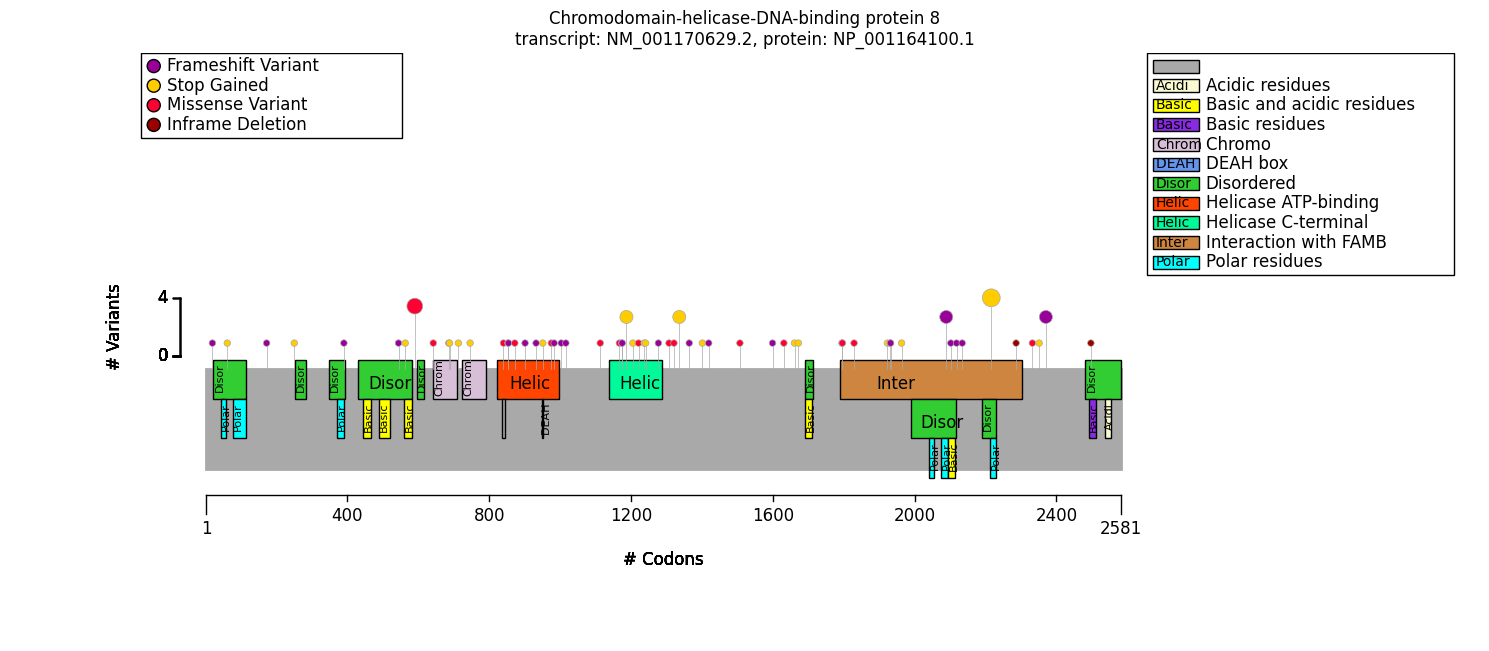

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

chd8_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
chd8_fig.tight_layout()

In [7]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
1,Disordered,Region,23 - 114,p.Ser62Ter
0,Polar residues,Compositional bias,44 - 58,
0,Polar residues,Compositional bias,77 - 114,
0,Disordered,Region,254 - 283,
1,Disordered,Region,350 - 392,p.Gln392ThrfsTer29
0,Polar residues,Compositional bias,371 - 389,
2,Disordered,Region,430 - 582,p.Lys545AsnfsTer47; p.Arg564Ter
0,Basic and acidic residues,Compositional bias,445 - 466,
0,Basic and acidic residues,Compositional bias,489 - 521,
1,Basic and acidic residues,Compositional bias,561 - 582,p.Arg564Ter


## Correlation Analysis

In [9]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest 
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [14]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_preds = monoallelic_classifier(a_predicate=is_missense,
                                        b_predicate=~is_missense,
                                        a_label="missense",
                                        b_label="other")

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_preds,
    pheno_clfs=pheno_predicates,
)


In [15]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo, missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Autistic behavior [HP:0000729]                         8/14     57%  45/50   
Autism [HP:0000717]                                    4/12     33%  31/44   
Intellectual disability [HP:0001249]                   8/12     67%  47/53   
Tall stature [HP:0000098]                               2/7     29%  21/32   
Motor delay [HP:0001270]                                3/6     50%  26/32   
Pes planus [HP:0001763]                                 4/9     44%   5/30   
Delayed speech and language development [HP:000...      4/8     50%  22/28   
Short attention span [HP:0000736]                      3/12     25%  14/31   
Macrocephaly [HP:0000256]                               2/7     29%  23/44   
Hypertelorism [HP:0000316]                              2/7     29%  15/32   
Constipation [HP:0002019]                               4/8     50%  13/38   
Diagnostic behavioral phenotype [HP:0025783]            8/8    100%  45/45   
Atypical behavior [HP:0000708]                          9/9    100%  49/49   
Neurodevelopmental abnormality [HP:0012759]           12/12    100%  57/57   
Abnormal axial skeleton morphology [HP:0009121]         3/3    100%  29/29   
Neurodevelopmental delay [HP:0012758]                   8/8    100%  30/30   
Prominent supraorbital ridges [HP:0000336]              4/6     67%  25/36   

Allele group                                                                   \
                                                   Percent Corrected p values   
Autistic behavior [HP:0000729]                         90%           0.164934   
Autism [HP:0000717]                                    70%           0.340942   
Intellectual disability [HP:0001249]                   89%           0.427153   
Tall stature [HP:0000098]                              66%           0.427153   
Motor delay [HP:0001270]                               81%           0.435660   
Pes planus [HP:0001763]                                17%           0.435660   
Delayed speech and language development [HP:000...     79%           0.435660   
Short attention span [HP:0000736]                      45%           0.651225   
Macrocephaly [HP:0000256]                              52%           0.684538   
Hypertelorism [HP:0000316]                             47%           0.684538   
Constipation [HP:0002019]                              34%           0.684538   
Diagnostic behavioral phenotype [HP:0025783]          100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Prominent supraorbital ridges [HP:0000336]             69%           1.000000   

Allele group                                                  
                                                    p values  
Autistic behavior [HP:0000729]                      0.009702  
Autism [HP:0000717]                                 0.040111  
Intellectual disability [HP:0001249]                0.077796  
Tall stature [HP:0000098]                           0.100507  
Motor delay [HP:0001270]                            0.131065  
Pes planus [HP:0001763]                             0.170223  
Delayed speech and language development [HP:000...  0.179390  
Short attention span [HP:0000736]                   0.306459  
Macrocephaly [HP:0000256]                           0.418917  
Hypertelorism [HP:0000316]                          0.438305  
Constipation [HP:0002019]                           0.442937  
Diagnostic behavioral phenotype [HP:0025783]        1.000000  
Atypical behavior [HP:0000708]                      1.000000  
Neurodevelopmental abnormality [

In [18]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Autism [HP:0000717]                                  7/19     37%  28/37   
Prominent supraorbital ridges [HP:0000336]           5/13     38%  24/29   
Autistic behavior [HP:0000729]                      12/18     67%  41/46   
Tall stature [HP:0000098]                             3/8     38%  20/31   
Intellectual disability, mild [HP:0001256]           9/22     41%  11/42   
Constipation [HP:0002019]                            7/14     50%  10/32   
Hypertelorism [HP:0000316]                           5/16     31%  12/23   
Delayed speech and language development [HP:000...   6/10     60%  20/26   
Anxiety [HP:0000739]                                  4/8     50%   8/24   
Intellectual disability [HP:0001249]                16/20     80%  39/45   
Macrocephaly [HP:0000256]                            5/13     38%  20/38   
Diagnostic behavioral phenotype [HP:0025783]        12/12    100%  41/41   
Atypical behavior [HP:0000708]                      12/12    100%  46/46   
Neurodevelopmental abnormality [HP:0012759]         22/22    100%  47/47   
Abnormal axial skeleton morphology [HP:0009121]       8/8    100%  24/24   
Short attention span [HP:0000736]                    5/14     36%  12/29   
Motor delay [HP:0001270]                             9/12     75%  20/26   
Neurodevelopmental delay [HP:0012758]               12/12    100%  26/26   

Sex                                                                            \
                                                   Percent Corrected p values   
Autism [HP:0000717]                                    76%           0.084207   
Prominent supraorbital ridges [HP:0000336]             83%           0.084207   
Autistic behavior [HP:0000729]                         89%           0.360658   
Tall stature [HP:0000098]                              65%           0.836040   
Intellectual disability, mild [HP:0001256]             26%           0.836040   
Constipation [HP:0002019]                              31%           0.836040   
Hypertelorism [HP:0000316]                             52%           0.836040   
Delayed speech and language development [HP:000...     77%           0.855846   
Anxiety [HP:0000739]                                   33%           0.855846   
Intellectual disability [HP:0001249]                   87%           0.855846   
Macrocephaly [HP:0000256]                              53%           0.855846   
Diagnostic behavioral phenotype [HP:0025783]          100%           1.000000   
Atypical behavior [HP:0000708]                        100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Short attention span [HP:0000736]                      41%           1.000000   
Motor delay [HP:0001270]                               77%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   

Sex                                                           
                                                    p values  
Autism [HP:0000717]                                 0.008006  
Prominent supraorbital ridges [HP:0000336]          0.009356  
Autistic behavior [HP:0000729]                      0.060110  
Tall stature [HP:0000098]                           0.234878  
Intellectual disability, mild [HP:0001256]          0.264484  
Constipation [HP:0002019]                           0.321471  
Hypertelorism [HP:0000316]                          0.325127  
Delayed speech and language development [HP:000...  0.412879  
Anxiety [HP:0000739]                                0.432509  
Intellectual disability [HP:0001249]                0.482231  
Macrocephaly [HP:0000256]                           0.523017  
Diagnostic behavioral phenotype [HP:002

In [19]:
from gpsea.analysis.pscore import DeVriesPhenotypeScorer, PhenotypeScoreAnalysis
from gpsea.analysis.pscore.stats import MannWhitneyStatistic

dv_scorer = DeVriesPhenotypeScorer(hpo)
mw_stats = MannWhitneyStatistic()

score_analysis = PhenotypeScoreAnalysis(mw_stats)
dv_missense_results = score_analysis.compare_genotype_vs_phenotype_score(cohort, missense_preds, dv_scorer)
df = dv_missense_results.data
df.head()
mean_missense = df[df["genotype"] == 0]["phenotype"].mean()
mean_other = df[df["genotype"] == 1]["phenotype"].mean()
pval = dv_missense_results.pval
message = f"DeVries score: missense: mean = {mean_missense:.3f}, other, mean = {mean_other:.3f}; p-val= {pval:.3e}"
print(message)

DeVries score: missense: mean = 1.111, other, mean = 1.992; p-val= 8.985e-04


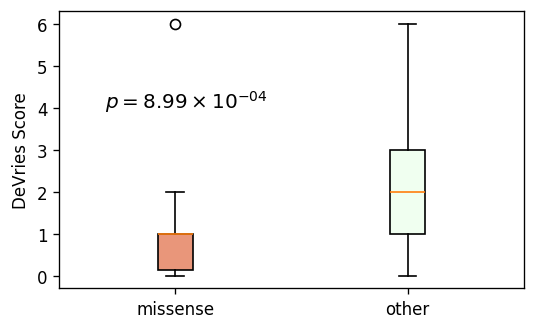

In [20]:
import matplotlib.pyplot as plt
dv_missense_fig, ax = plt.subplots(figsize=(5, 3), dpi=120)
ax.set_ylabel("DeVries Score")
pval_text= f"p = {pval:.2e}".replace('e', '\\times 10^{').replace('+', '') + '}'
#ax.text(x=30, y=0.6, s=f"${s}$", fontsize=12)

plt.text(0.7, 4, f"${pval_text}$", fontsize=12)
dv_missense_results.plot_boxplots(ax=ax)

# Summary

In [27]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


f_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,
    )
)

m_results = (
    GPAnalysisResultSummary.from_multi(
        result=dv_missense_results
    ),
)

caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [28]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

ValueError: The 'gpseacs' package was not installed in a way that PackageLoader understands.

In [15]:
summarizer.process_latex(report=report, protein_fig=chd8_fig, stats_fig=dv_missense_fig)

Figure saved to ../../supplement/img/CHD8_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CHD8_stats-draft.pdf
Output to ../../supplement/tex/CHD8_summary_draft.tex
